# Importações

In [15]:
import graphviz
import numpy as np
import pandas as pd

import shap
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# Pré-processamento

In [2]:
dadosMedicos = pd.read_csv(rf'..\2015.csv', sep=';')
dadosMedicos

C:\Users\isabe\AppData\Local\Temp\ipykernel_6444\219197495.py:1: DtypeWarning: Columns (96,97,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  dadosMedicos = pd.read_csv(rf'..\2015.csv', sep=';')


,UF_ZI,ANO_CMPT,MES_CMPT,ESPEC,CGC_HOSP,N_AIH,IDENT,CEP,MUNIC_RES,NASC,...,DIAGSEC9,TPDISEC1,TPDISEC2,TPDISEC3,TPDISEC4,TPDISEC5,TPDISEC6,TPDISEC7,TPDISEC8,TPDISEC9
0,120000,2015,1,1,6.360294e+13,1215100018110,1,69900970,120040,19691208,...,NaN,1,0,0,0,0,0,0,0,0
1,120000,2015,1,1,6.360294e+13,1215100018198,1,69900970,120040,19730513,...,NaN,1,0,0,0,0,0,0,0,0
2,120000,2015,1,1,6.360294e+13,1215100018341,1,69921000,120080,19530312,...,NaN,1,0,0,0,0,0,0,0,0
3,120000,2015,1,1,6.360294e+13,1215100018363,1,69900970,120040,19910618,...,NaN,1,0,0,0,0,0,0,0,0
4,120000,2015,1,1,6.360294e+13,1215100018385,1,69960000,120030,19950619,...,NaN,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,110000,2015,2,1,6.074262e+13,1115500004542,1,76900100,110012,19460501,...,NaN,0,0,0,0,0,0,0,0,0
1048571,110000,2015,2,1,6.074262e+13,1115500004553,1,76868000,110013,19560826,...,NaN,0,0,0,0,0,0,0,0,0
1048572,110000,2015,2,1,6.074262e+13,1115500004510,1,76801000,110020,19510602,...,NaN,0,0,0,0,0,0,0,0,0
1048573,110000,2015,2,1,4.287520e+12,1115100053254,1,76801000,110020,19711106,...,NaN,0,0,0,0,0,0,0,0,0


In [3]:
data = dadosMedicos.copy()

# Remover colunas inteiras vazias
data = data.dropna(how='all', axis=1)

# Remover colunas com todos os valores iguais
colunas_com_valores_unicos = data.nunique() == 1
if colunas_com_valores_unicos.any():
    data = data.drop(data.columns[colunas_com_valores_unicos], axis=1)

# # Remover algumas colunas específicas
# data = data.drop(columns=['DIAS_PERM', 'NASC', 'CEP', 'MES_CMPT', 'NATUREZA', 'TPDISEC5', 'DIAR_ACOM', 'SEQUENCIA', 'REMESSA', 'VAL_SH', 'VAL_SP', 'VAL_TOT', 'US_TOT', 'VAL_SH_FED', 'VAL_SP_FED', 'VAL_SH_GES', 'VAL_SP_GES', 'VAL_UCI'])

# Considerar apenas financiamento Faec (04)
mask = data['FINANC'] != 4
data = data.drop(data[mask == True].index)

data = data[['CEP', 'MUNIC_MOV', 'PROC_REA', 'DIAG_PRINC', 'DIAGSEC1', 'DIAGSEC2', 'DIAGSEC3', 'DIAGSEC4', 'MORTE', 'CNES', 'QT_DIARIAS', 'VAL_TOT']]

# # Remover idades zeradas
# mask = data['IDADE'] != 0
# data = data.drop(data[mask == False].index)

#Transformar dados string em numéricos
obj_cols = list(data.select_dtypes(include='object').columns)
data[obj_cols] = data[obj_cols].apply(lambda x: x.str.replace(',','.'))
data['VAL_TOT'] = data['VAL_TOT'].astype(float)

# Preencher células vazias com 0
data = data.fillna(0)

data

,CEP,MUNIC_MOV,PROC_REA,DIAG_PRINC,DIAGSEC1,DIAGSEC2,DIAGSEC3,DIAGSEC4,MORTE,CNES,QT_DIARIAS,VAL_TOT
6,69945000,120040,404010032,J351,W199,0,0,0,0,2001586,2,353.22
7,69950000,120040,404010482,J342,W199,0,0,0,0,2001586,1,247.46
9,69900970,120040,407020276,K605,W199,0,0,0,0,2001586,1,254.12
10,69900970,120040,401020070,L720,W199,0,0,0,0,2001586,1,143.72
11,69900970,120040,407030026,K800,W199,0,0,0,0,2001586,2,741.11
...,...,...,...,...,...,...,...,...,...,...,...,...
1048569,76801000,110020,405050372,H251,0,0,0,0,0,2807092,1,651.00
1048570,76900100,110020,405050372,H251,0,0,0,0,0,2807092,1,651.00
1048571,76868000,110020,405050372,H251,0,0,0,0,0,2807092,1,643.00
1048572,76801000,110020,405050372,H251,0,0,0,0,0,2807092,1,651.00


In [4]:
def encontrar_indice_true(lista):
  for indice, valor in enumerate(lista):
    if valor == True:
      print(colunas_com_valores_unicos.index[indice])


# Exemplo de uso
encontrar_indice_true(colunas_com_valores_unicos)

ANO_CMPT
IDENT
UTI_MES_IN
UTI_MES_AN
UTI_MES_AL
UTI_INT_IN
UTI_INT_AN
UTI_INT_AL
VAL_SADT
VAL_RN
VAL_ACOMP
VAL_ORTP
VAL_SANGUE
VAL_SADTSR
VAL_TRANSP
VAL_OBSANG
VAL_PED1AC
DIAG_SECUN
RUBRICA
CAR_INT
TOT_PT_SP
SEQ_AIH5
CID_ASSO
CID_MORTE
DIAGSEC5
TPDISEC6
TPDISEC7
TPDISEC8
TPDISEC9


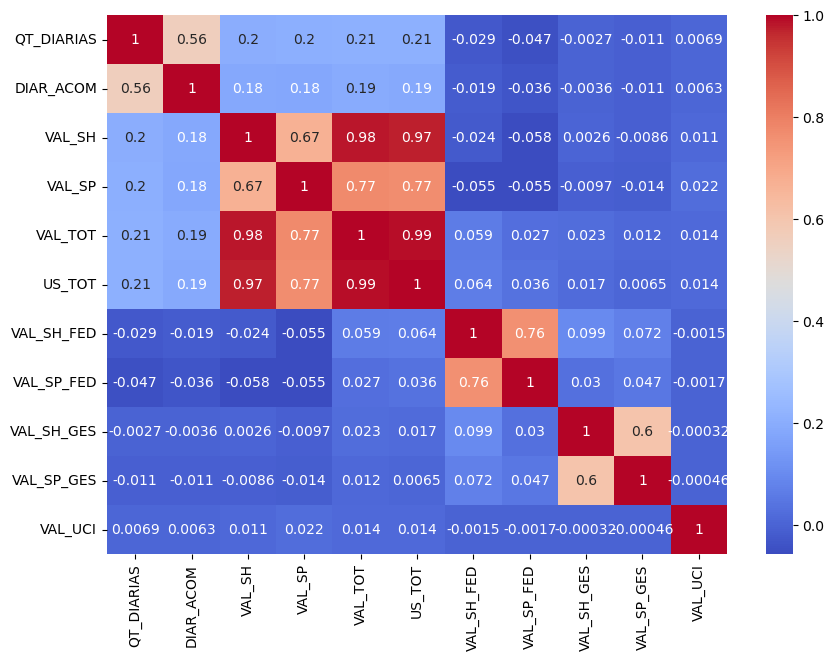

In [5]:
correlacao = dadosMedicos.copy()
correlacao = correlacao[['QT_DIARIAS', 'DIAR_ACOM', 'VAL_SH', 'VAL_SP', 'VAL_TOT', 'US_TOT', 'VAL_SH_FED', 'VAL_SP_FED', 'VAL_SH_GES', 'VAL_SP_GES', 'VAL_UCI']]
correlacao[['VAL_SH', 'VAL_SP', 'VAL_TOT', 'US_TOT', 'VAL_SH_FED', 'VAL_SP_FED', 'VAL_SH_GES', 'VAL_SP_GES', 'VAL_UCI']] = correlacao[['VAL_SH', 'VAL_SP', 'VAL_TOT', 'US_TOT', 'VAL_SH_FED', 'VAL_SP_FED', 'VAL_SH_GES', 'VAL_SP_GES', 'VAL_UCI']].apply(lambda x: x.str.replace(',','.'))
correlacao[['VAL_SH', 'VAL_SP', 'VAL_TOT', 'US_TOT', 'VAL_SH_FED', 'VAL_SP_FED', 'VAL_SH_GES', 'VAL_SP_GES', 'VAL_UCI']] = correlacao[['VAL_SH', 'VAL_SP', 'VAL_TOT', 'US_TOT', 'VAL_SH_FED', 'VAL_SP_FED', 'VAL_SH_GES', 'VAL_SP_GES', 'VAL_UCI']].astype(float)
correlation_matrix = correlacao.corr()

plt.figure(figsize=(10,7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.savefig('imagens/correlation_matrix_removal')
plt.show()


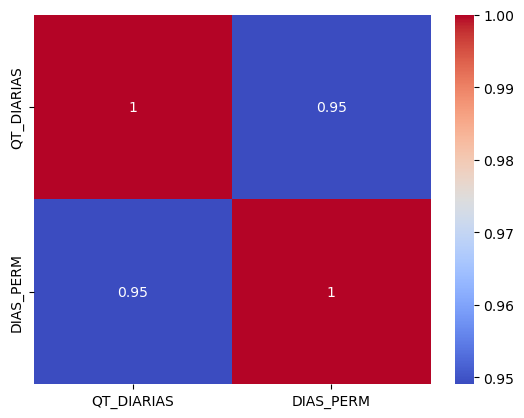

In [30]:
correlacao = dadosMedicos.copy()
correlacao = correlacao[['QT_DIARIAS', 'DIAS_PERM']]
correlation_matrix = correlacao.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.savefig('imagens/correlation_matrix_dias')
plt.show()

In [5]:
data.to_csv(rf'..\2015_dados_selecionados.csv')

# Treinamento do modelo

In [4]:
temp = data.copy()
y = temp['QT_DIARIAS'].copy()

temp = temp.drop(columns=['QT_DIARIAS', 'VAL_TOT', 'DIAG_PRINC', 'DIAGSEC1', 'DIAGSEC2', 'DIAGSEC3', 'DIAGSEC4'])

# # Colunas Diagnóstico
# colunas = ['DIAG_PRINC', 'DIAGSEC1', 'DIAGSEC2', 'DIAGSEC3', 'DIAGSEC4']

# # Gera os dummies
# dummies = pd.get_dummies(temp[colunas].astype(str))

# # Agrupa por valor (ignorando o prefixo da coluna)
# dummies.columns = dummies.columns.str.split('_').str[1]

# # Faz o OR lógico entre colunas com o mesmo valor (ou seja, se apareceu em qualquer coluna)
# dummies = dummies.groupby(level=0, axis=1).max()

# # Resultado final (True/False ao invés de 1/0 se quiser)
# dummies = dummies.astype(bool)

# temp = pd.concat([temp, dummies], axis=1)
# # temp = pd.get_dummies(temp)
# temp = temp.drop(columns=colunas)
# temp = temp.drop(columns=['0', 'PRINC'])
X = temp.copy()
X = X.astype(float)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# fit model
single_split_model = GaussianNB()
single_split_model.fit(X_train, y_train)

GaussianNB()

In [23]:
from sklearn.model_selection import cross_val_score
cross_val_score(single_split_model, X_test, y_test, cv=10)

d:\Users\isabe\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


array([0.58877964, 0.58718913, 0.58921342, 0.59060014, 0.59103398,
       0.5923355 , 0.60202458, 0.59913232, 0.58973247, 0.59002169])

In [22]:
single_split_model.score(X_test, y_test)

0.5985423625873064

# Aplicação de métodos de Machine Learning

In [6]:
temp = data.copy()
y = temp['QT_DIARIAS'].copy()

temp = temp.drop(columns=['QT_DIARIAS', 'VAL_TOT'])

# Colunas Diagnóstico
colunas = ['DIAG_PRINC', 'DIAGSEC1', 'DIAGSEC2', 'DIAGSEC3', 'DIAGSEC4']

# Gera os dummies
dummies = pd.get_dummies(temp[colunas].astype(str))

# Agrupa por valor (ignorando o prefixo da coluna)
dummies.columns = dummies.columns.str.split('_').str[1]

# Faz o OR lógico entre colunas com o mesmo valor (ou seja, se apareceu em qualquer coluna)
dummies = dummies.groupby(level=0, axis=1).max()

# Resultado final (True/False ao invés de 1/0 se quiser)
dummies = dummies.astype(bool)

temp = pd.concat([temp, dummies], axis=1)
# temp = pd.get_dummies(temp)
temp = temp.drop(columns=colunas)
temp = temp.drop(columns=['0', 'PRINC'])
X = temp.copy()
X = X.astype(float)

C:\Users\isabe\AppData\Local\Temp\ipykernel_6444\1312602094.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  dummies = dummies.groupby(level=0, axis=1).max()


In [39]:
explainer = shap.Explainer(single_split_model.predict, X_train)
shap_values = explainer(X_train)

ExactExplainer explainer: 161357it [37:50, 70.71it/s]                             


C:\Users\isabe\AppData\Local\Temp\ipykernel_18652\3022310071.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


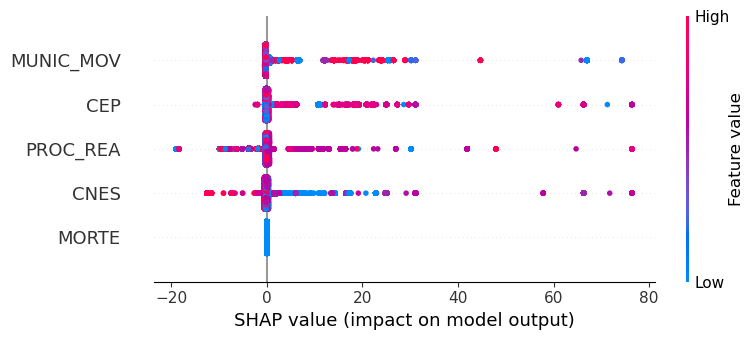

In [40]:
shap.summary_plot(shap_values, X_train)

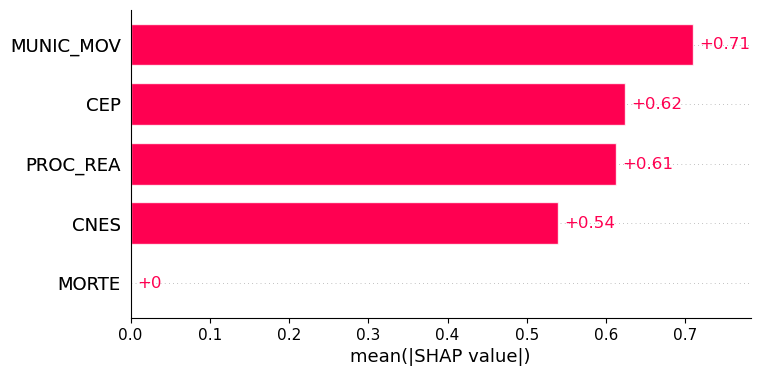

In [41]:
shap.plots.bar(shap_values)

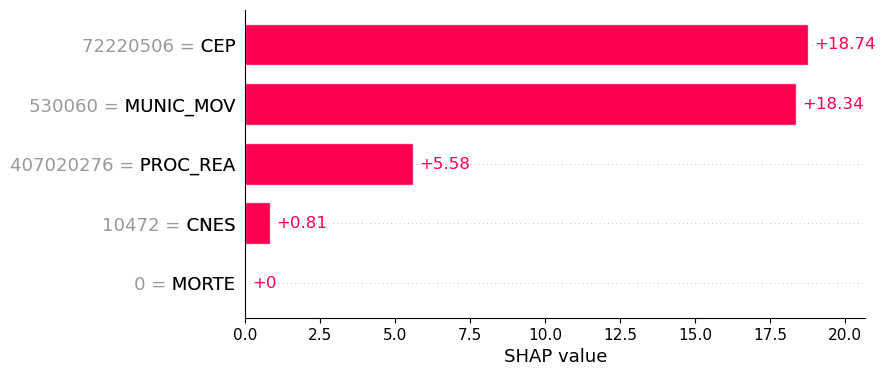

In [42]:
shap.plots.bar(shap_values[0])

# Avaliando apenas os diagnósticos

In [167]:
diagnosticos_principais = ['Y831','V091','W038','W019']
for diag in diagnosticos_principais:
    try:
        print(f'{diag}: {data['DIAGSEC1'].value_counts()[diag]}')
    except:
        next

Y831: 38
V091: 24
W038: 1
W019: 108


In [206]:
test = data.loc[data['DIAGSEC1'] == 'Y831']
test = test.loc[test['DIAG_PRINC'] == 'T840']
# test['DIAG_PRINC'].value_counts()
test['QT_DIARIAS'].mean()

19.48

7.176470588235294


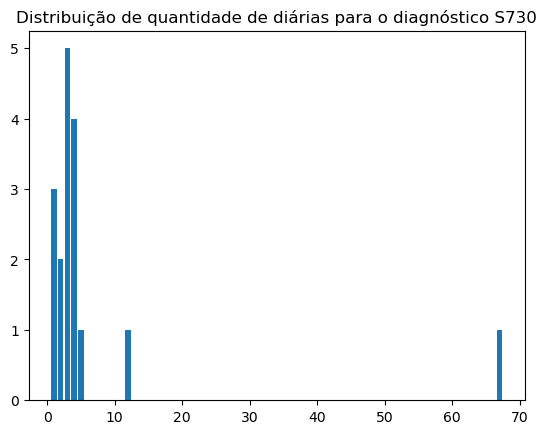

In [201]:
# test = data.loc[data['DIAGSEC1'] == 'W038']
test = data.loc[data['DIAG_PRINC'] == 'S730']

print(test['QT_DIARIAS'].mean())


plt.figure()
plt.title('Distribuição de quantidade de diárias para o diagnóstico S730')
plt.bar(test['QT_DIARIAS'].value_counts().index, test['QT_DIARIAS'].value_counts())

plt.savefig('imagens/S835.png')

1.663978494623656


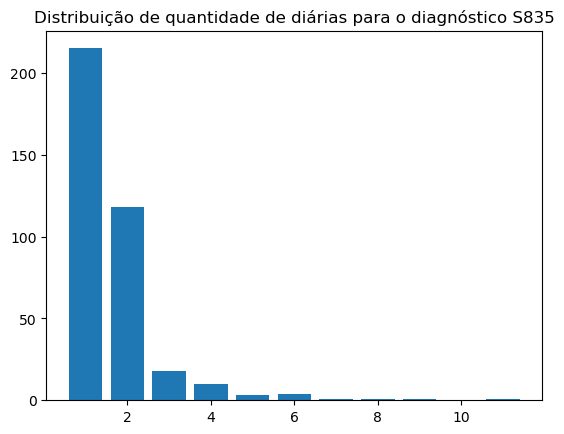

In [195]:
test = data.loc[data['DIAGSEC1'] == 'W019']
test = data.loc[data['DIAG_PRINC'] == 'S835']

print(test['QT_DIARIAS'].mean())


plt.figure()
plt.title('Distribuição de quantidade de diárias para o diagnóstico S835')
plt.bar(test['QT_DIARIAS'].value_counts().index, test['QT_DIARIAS'].value_counts())

plt.savefig('imagens/S835.png')

26.72222222222222


<BarContainer object of 12 artists>

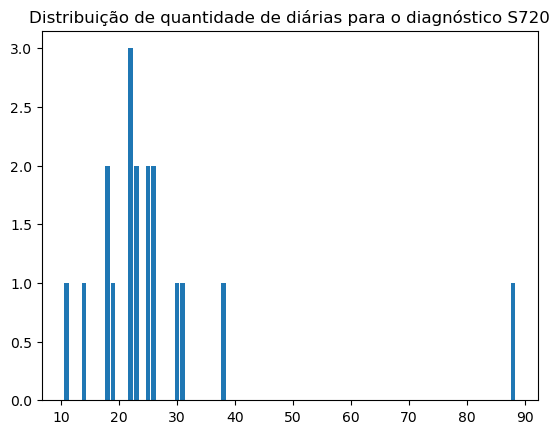

In [200]:
test = data.loc[data['DIAGSEC1'] == 'W019']
test = test.loc[test['DIAG_PRINC'] == 'S720']

print(test['QT_DIARIAS'].mean())


plt.figure()
plt.title('Distribuição de quantidade de diárias para o diagnóstico S720')
plt.bar(test['QT_DIARIAS'].value_counts().index, test['QT_DIARIAS'].value_counts())

<BarContainer object of 13 artists>

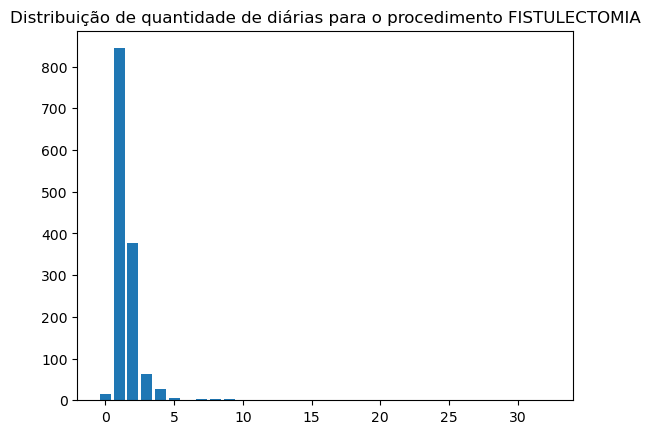

In [ ]:
test = data.loc[data['PROC_REA'] == 407020276]

import matplotlib.pyplot as plt

plt.figure()
plt.title('Distribuição de quantidade de diárias para o procedimento FISTULECTOMIA')
plt.bar(test['QT_DIARIAS'].value_counts().index, test['QT_DIARIAS'].value_counts())

In [180]:
test.sort_values(by='QT_DIARIAS')

,CEP,MUNIC_MOV,PROC_REA,DIAG_PRINC,DIAGSEC1,DIAGSEC2,DIAGSEC3,DIAGSEC4,MORTE,CNES,QT_DIARIAS,VAL_TOT
571165,30720100,310620,407020276,K603,0,0,0,0,0,2192896,0,529.51
570086,31010514,310620,407020276,K603,0,0,0,0,0,2192896,0,505.51
556244,35701411,310620,407020276,K603,0,0,0,0,0,2192896,0,529.51
556153,30865090,310620,407020276,K603,0,0,0,0,0,2192896,0,529.51
556058,30510540,310620,407020276,K603,0,0,0,0,0,2192896,0,529.51
...,...,...,...,...,...,...,...,...,...,...,...,...
393081,65360000,210690,407020276,K603,0,0,0,0,0,7321252,9,553.46
252945,72450105,530060,407020276,K610,0,0,0,0,1,10472,9,318.12
252939,72450120,530060,407020276,K610,0,0,0,0,0,10472,10,334.12
316550,76465000,520870,407020276,K603,0,0,0,0,0,2519151,14,628.24


In [4]:
diagnosticos = []

for i in list(data['DIAG_PRINC'].value_counts().head(10).index):
    diagnosticos.append(str(i))

diagnosticos = list(set(diagnosticos))
diagnosticos

['K810', 'K409', 'K429', 'I839', 'Z302', 'K800', 'N47', 'D259', 'K802', 'K808']

In [42]:
dummies_most = dummies[diagnosticos]

In [43]:
dummies_train, dummies_test, y_dummies_train, y_dummies_test = train_test_split(dummies_most, y, test_size=0.3, random_state=42)

In [44]:
# fit model
single_split_model = GaussianNB()
single_split_model.fit(dummies_train, y_dummies_train)

GaussianNB()

In [48]:
single_split_model.score(dummies_test, y_dummies_test)

0.0111925729903258

In [52]:
dummies_train

,K810,K409,K429,I839,Z302,K800,N47,D259,K802,K808
264444,False,False,False,False,False,False,False,False,False,False
294929,False,False,False,False,False,False,False,False,False,False
291720,False,False,False,False,False,False,False,False,False,False
64069,False,False,False,False,False,False,False,False,False,False
818226,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
450483,False,False,False,False,False,False,False,False,False,False
413590,False,False,False,False,False,False,False,False,False,False
482878,False,False,False,False,False,False,False,False,False,False
539346,False,False,False,False,False,False,False,False,False,False


In [60]:
explainer = shap.Explainer(single_split_model.predict, dummies_train)
shap_values = explainer(dummies_train)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [235]:
shap.summary_plot(shap_values, dummies_train)

C:\Users\isabe\AppData\Local\Temp\ipykernel_18652\3533711746.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, dummies_train)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>

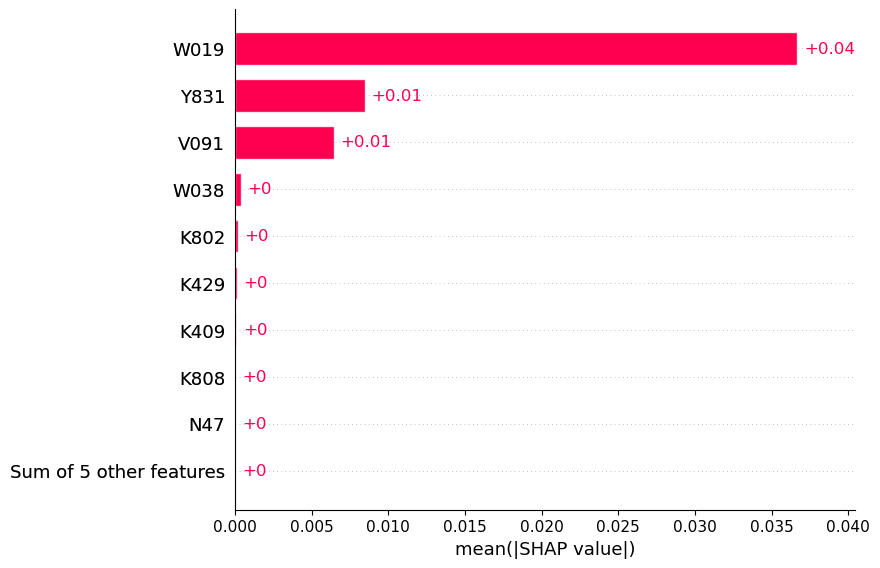

In [141]:
shap.plots.bar(shap_values)

In [ ]:
diagnosticos = []

for i in list(data['DIAGSEC1'].value_counts().head(11).index):
    diagnosticos.append(str(i))

# for i in list(data['DIAGSEC2'].value_counts().head(3).index):
#     diagnosticos.append(str(i))

# for i in list(data['DIAGSEC3'].value_counts().head(15).index):
#     diagnosticos.append(str(i))

# for i in list(data['DIAGSEC4'].value_counts().head(15).index):
#     diagnosticos.append(str(i))

diagnosticos.append('Y831')
diagnosticos.append('V091')
diagnosticos.append('W038')
diagnosticos.append('W019')

diagnosticos = list(set(diagnosticos))

In [131]:
dummies_most = dummies[diagnosticos]
dummies_most.drop('0', axis=1, inplace=True)

C:\Users\isabe\AppData\Local\Temp\ipykernel_18652\3637540010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummies_most.drop('0', axis=1, inplace=True)


In [132]:
dummies_train, dummies_test, y_dummies_train, y_dummies_test = train_test_split(dummies_most, y, test_size=0.3, random_state=42)

In [229]:
# fit model
single_split_model = GaussianNB(var_smoothing=1)
single_split_model.fit(dummies_train, y_dummies_train)

explainer = shap.Explainer(single_split_model.predict, dummies_train)
shap_values = explainer(dummies_train)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
shap.summary_plot(shap_values, dummies_train)

In [ ]:
shap.plots.bar(shap_values)

# Avaliando apenas os diagnósticos mais importantes

In [ ]:
temp = data.copy()

y = temp['QT_DIARIAS'].copy()

# Colunas Diagnóstico
colunas = ['DIAG_PRINC', 'DIAGSEC1', 'DIAGSEC2', 'DIAGSEC3', 'DIAGSEC4']

# temp['QT_DIARIAS'] = temp['QT_DIARIAS'].astype(int)

# Gera os dummies
dummies_filter = pd.get_dummies(temp[colunas].astype(str))

# Agrupa por valor (ignorando o prefixo da coluna)
dummies_filter.columns = dummies_filter.columns.str.split('_').str[1]

# Faz o OR lógico entre colunas com o mesmo valor (ou seja, se apareceu em qualquer coluna)
dummies_filter = dummies_filter.groupby(level=0, axis=1).max()

# Resultado final (True/False ao invés de 1/0 se quiser)
dummies_filter = dummies_filter.astype(bool)

dummies_filter = pd.concat([y, dummies_filter], axis=1)

dummies_filter = dummies_filter.query('W019 == 1 or Y831 == 1 or V091 == 1 or W038 == 1')

colunas_com_valores_unicos = dummies_filter.nunique() == 1
if colunas_com_valores_unicos.any():
    dummies_filter = dummies_filter.drop(dummies_filter.columns[colunas_com_valores_unicos], axis=1)

# dummies_filter

y = dummies_filter['QT_DIARIAS'].copy()

dummies_filter.pop('QT_DIARIAS');

# temp = pd.concat([temp, dummies_filter], axis=1)
# # temp = pd.get_dummies(temp)
# temp = temp.drop(columns=colunas)
# temp = temp.drop(columns=['0', 'PRINC'])

C:\Users\isabe\AppData\Local\Temp\ipykernel_18652\2204600906.py:17: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  dummies_filter = dummies_filter.groupby(level=0, axis=1).max()


In [35]:
# fit model
single_split_model = GaussianNB()
single_split_model.fit(dummies_filter, y)

explainer = shap.Explainer(single_split_model.predict, dummies_filter)
shap_values = explainer(dummies_filter)

C:\Users\isabe\AppData\Local\Temp\ipykernel_18652\2642951060.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, dummies_filter)


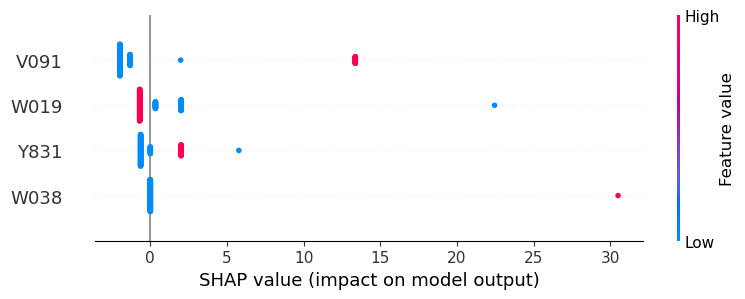

In [36]:
shap.summary_plot(shap_values, dummies_filter)

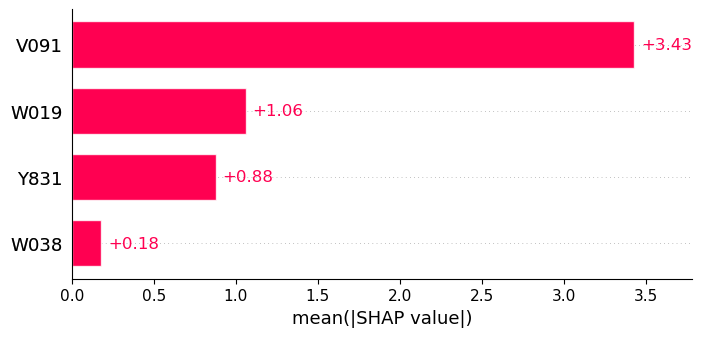

In [37]:
shap.plots.bar(shap_values)